In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Cell 2: Load Cleaned Data
df = pd.read_csv('../data/cleaned_data_long.csv')

print("=== DATA LOADED ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nYears: {df['year'].min()} - {df['year'].max()}")
print(f"Items: {df['item'].nunique()}")
print(f"\nSample:")
df.head()

=== DATA LOADED ===
Shape: (2113, 6)
Columns: ['year', 'item', 'expenditure_bracket', 'value', 'category', 'bracket_order']

Years: 2013 - 2025
Items: 21

Sample:


,year,item,expenditure_bracket,value,category,bracket_order
0,2013,Padi-padian,Kurang dari 100 000,29722.0,Food,1
1,2013,Padi-padian,100 000- 149 999,43372.0,Food,2
2,2013,Padi-padian,150 000- 199 999,47289.0,Food,3
3,2013,Padi-padian,200 000- 299 999,52588.0,Food,4
4,2013,Padi-padian,300 000- 499 999,59869.0,Food,5


## Fix Unit Inconsistency

BPS mengubah unit pengukuran:
- **2013-2015:** Rupiah penuh (contoh: 1,368,616)
- **2016-2021:** Ribuan Rupiah (contoh: 1,034.157 = 1 juta)
- **2022-2025:** Rupiah penuh kembali



In [22]:
# Cell 2b: Detect and Fix Unit Inconsistency
print("=== UNIT CONSISTENCY CHECK ===")

# Check average consumption per year
year_avg = df.groupby('year')['value'].mean()
print("\nAverage consumption per year:")
print(year_avg)

# Detect years with values < 10,000 (likely in thousands)
low_value_years = year_avg[year_avg < 10000].index.tolist()
print(f"\n Years with avg < 10,000 (likely in THOUSANDS): {low_value_years}")

# Apply correction: multiply by 1000
if len(low_value_years) > 0:
    print(f"\n Applying correction: multiplying by 1000 for years {low_value_years}")
    mask_thousands = df['year'].isin(low_value_years)
    records_affected = mask_thousands.sum()
    
    df.loc[mask_thousands, 'value'] = df.loc[mask_thousands, 'value'] * 1000
    
    print(f" Corrected {records_affected:,} records")
    
    # Verify correction
    year_avg_after = df.groupby('year')['value'].mean()
    print(f"\nAverage after correction:")
    print(year_avg_after)
else:
    print("\n No correction needed - all years in consistent units")

=== UNIT CONSISTENCY CHECK ===

Average consumption per year:
year
2013    21786.337349
2014    22965.474684
2015    32949.482143
2016    49774.839286
2017    47414.934524
2018    46213.869048
2019    54474.053571
2020    39025.227545
2021    69059.006173
2022    50954.103030
2023    43852.577640
2024    50982.040816
2025    51996.972789
Name: value, dtype: float64

 Years with avg < 10,000 (likely in THOUSANDS): []

 No correction needed - all years in consistent units


In [26]:
# Cell 2c: Verify Fix with Sample Data
print("=== VERIFICATION: Sample Data After Fix ===")

# Show same item across years to verify consistency
sample_item = 'Padi-padian'
sample_bracket = '200 000- 299 999'

sample_data = df[(df['item'] == sample_item) & (df['expenditure_bracket'] == sample_bracket)][
    ['year', 'item', 'expenditure_bracket', 'value']
].sort_values('year')

if len(sample_data) > 0:
    print(f"\n{sample_item} at bracket '{sample_bracket}':")
    print(sample_data.to_string(index=False))
    
    # Check if values are in reasonable range now
    value_range = sample_data['value'].max() / sample_data['value'].min()
    print(f"\nValue range ratio (max/min): {value_range:.2f}")
    
    if value_range < 1000:  # Reasonable range
        print(" Values look consistent across years!")
    else:
        print(" Still large variation - check data manually")
else:
    print(f"Sample data not found - using different item/bracket")
    alt_sample = df.groupby('year')['value'].mean().to_frame('avg_value')
    print(alt_sample)

=== VERIFICATION: Sample Data After Fix ===

Padi-padian at bracket '200 000- 299 999':
 year        item expenditure_bracket   value
 2013 Padi-padian    200 000- 299 999 52588.0
 2014 Padi-padian    200 000- 299 999 53929.0
 2015 Padi-padian    200 000- 299 999 55830.0
 2016 Padi-padian    200 000- 299 999 52212.0
 2017 Padi-padian    200 000- 299 999 51740.0
 2018 Padi-padian    200 000- 299 999 52564.0
 2019 Padi-padian    200 000- 299 999 53600.0
 2020 Padi-padian    200 000- 299 999 56546.0
 2021 Padi-padian    200 000- 299 999 57554.0
 2022 Padi-padian    200 000- 299 999 55400.0
 2023 Padi-padian    200 000- 299 999 53812.0
 2024 Padi-padian    200 000- 299 999 63430.0
 2025 Padi-padian    200 000- 299 999 58756.0

Value range ratio (max/min): 1.23
 Values look consistent across years!


## 1. Coefficient of Variation (CV) Analysis

CV = (Standard Deviation / Mean) × 100%

**Interpretasi:**
- CV tinggi = ketimpangan tinggi antar golongan pengeluaran
- CV rendah = distribusi merata

In [5]:
# Cell 3: Calculate CV per Item per Year
def coefficient_of_variation(x):
    """Calculate CV as percentage"""
    mean = x.mean()
    if mean == 0:
        return np.nan
    return (x.std() / mean) * 100

# CV per item per year (across expenditure brackets)
cv_item_year = df.groupby(['year', 'item', 'category'])['value'].agg(
    mean='mean',
    std='std',
    cv=coefficient_of_variation,
    min='min',
    max='max'
).reset_index()

# Add range ratio (max/min) - another inequality measure
cv_item_year['range_ratio'] = cv_item_year['max'] / cv_item_year['min'].replace(0, np.nan)

print("=== CV PER ITEM PER YEAR ===")
print(f"Shape: {cv_item_year.shape}")
print(f"\nTop 10 highest CV (most unequal distribution):")
print(cv_item_year.nlargest(10, 'cv')[['year', 'item', 'cv', 'range_ratio']])

=== CV PER ITEM PER YEAR ===
Shape: (273, 9)

Top 10 highest CV (most unequal distribution):
     year                                  item          cv  range_ratio
137  2019                      Konsumsi lainnya  256.657153   463.503650
168  2021                         Bahan minuman  244.460867   150.384744
261  2025                       Kacang-kacangan  242.550068   206.677639
72   2016                       Kacang-kacangan  241.529474   115.443425
234  2024                       Biaya kesehatan  236.052450   415.006359
171  2021                       Biaya kesehatan  234.115783   602.392681
157  2020           Keperluan pesta dan upacara  233.952469   626.452189
255  2025                       Biaya kesehatan  231.470242   402.823920
183  2021  Pakaian, alas kaki, dan tutup kepala  231.299326   274.221157
2    2013                Barang yang tahan lama  226.758524  1011.221739


In [6]:
# Cell 4: CV Trend Analysis - Food vs Non-Food
cv_by_category_year = cv_item_year.groupby(['year', 'category'])['cv'].mean().reset_index()
cv_pivot = cv_by_category_year.pivot(index='year', columns='category', values='cv')

print("=== CV TREND: FOOD vs NON-FOOD ===")
print(cv_pivot)
print(f"\n--- ANALYTICAL INSIGHT ---")
print(f"Food CV range: {cv_pivot['Food'].min():.1f}% - {cv_pivot['Food'].max():.1f}%")
print(f"Non-Food CV range: {cv_pivot['Non-Food'].min():.1f}% - {cv_pivot['Non-Food'].max():.1f}%")
print(f"\nNon-Food has {'HIGHER' if cv_pivot['Non-Food'].mean() > cv_pivot['Food'].mean() else 'LOWER'} inequality than Food")

=== CV TREND: FOOD vs NON-FOOD ===
category        Food    Non-Food
year                            
2013       72.555494  141.628583
2014       69.808449  144.089385
2015       74.861965  141.978183
2016       89.730591  122.266280
2017       78.434682  116.771229
2018       73.639436  117.920518
2019       86.976330  111.156516
2020       72.670614  143.354416
2021      108.735613  154.430672
2022       88.484788  118.945412
2023       81.560077  116.872795
2024       85.023906  126.574561
2025       84.391371  123.481963

--- ANALYTICAL INSIGHT ---
Food CV range: 69.8% - 108.7%
Non-Food CV range: 111.2% - 154.4%

Non-Food has HIGHER inequality than Food


In [7]:
# Cell 5: Identify Structural Breaks in CV
# Pre-COVID (2013-2019) vs COVID (2020-2021) vs Post-COVID (2022-2025)

def get_period(year):
    if year <= 2019:
        return 'Pre-COVID (2013-2019)'
    elif year <= 2021:
        return 'COVID (2020-2021)'
    else:
        return 'Post-COVID (2022-2025)'

cv_item_year['period'] = cv_item_year['year'].apply(get_period)

# Compare CV across periods
period_analysis = cv_item_year.groupby(['period', 'category'])['cv'].agg(['mean', 'std']).round(2)

print("=== CV BY PERIOD (Structural Analysis) ===")
print(period_analysis)

# Statistical test: is there significant difference?
pre_covid = cv_item_year[cv_item_year['period'] == 'Pre-COVID (2013-2019)']['cv']
post_covid = cv_item_year[cv_item_year['period'] == 'Post-COVID (2022-2025)']['cv']

t_stat, p_value = stats.ttest_ind(pre_covid.dropna(), post_covid.dropna())
print(f"\n--- STATISTICAL TEST ---")
print(f"T-test Pre vs Post COVID: t={t_stat:.3f}, p={p_value:.4f}")
print(f"Difference is {'SIGNIFICANT' if p_value < 0.05 else 'NOT significant'} at α=0.05")

=== CV BY PERIOD (Structural Analysis) ===
                                   mean    std
period                 category               
COVID (2020-2021)      Food       90.70  49.75
                       Non-Food  148.89  60.75
Post-COVID (2022-2025) Food       84.87  39.67
                       Non-Food  121.47  47.69
Pre-COVID (2013-2019)  Food       78.00  35.56
                       Non-Food  127.97  39.20

--- STATISTICAL TEST ---
T-test Pre vs Post COVID: t=-0.288, p=0.7734
Difference is NOT significant at α=0.05


## 2. Consumption Structure Analysis

In [8]:
# Cell 6: Calculate Consumption Proportions
# Total consumption per bracket per year
total_by_bracket_year = df.groupby(['year', 'expenditure_bracket', 'bracket_order'])['value'].sum().reset_index()
total_by_bracket_year.columns = ['year', 'expenditure_bracket', 'bracket_order', 'total_consumption']

# Merge back to get proportions
df_with_total = df.merge(total_by_bracket_year, on=['year', 'expenditure_bracket', 'bracket_order'])
df_with_total['proportion'] = df_with_total['value'] / df_with_total['total_consumption'] * 100

print("=== CONSUMPTION PROPORTIONS ===")
print(f"Added 'proportion' column (% of total bracket consumption)")
df_with_total[['year', 'item', 'expenditure_bracket', 'value', 'total_consumption', 'proportion']].head(10)

=== CONSUMPTION PROPORTIONS ===
Added 'proportion' column (% of total bracket consumption)


,year,item,expenditure_bracket,value,total_consumption,proportion
0,2013,Padi-padian,Kurang dari 100 000,29722.0,78984.0,37.630406
1,2013,Padi-padian,100 000- 149 999,43372.0,130020.0,33.357945
2,2013,Padi-padian,150 000- 199 999,47289.0,168997.0,27.982154
3,2013,Padi-padian,200 000- 299 999,52588.0,231773.0,22.689442
4,2013,Padi-padian,300 000- 499 999,59869.0,347133.0,17.246704
5,2013,Padi-padian,500 000- 749 999,70880.0,533444.0,13.287243
6,2013,Padi-padian,750 000- 999 999,77894.0,757565.0,10.282154
7,2013,Padi-padian,1 000 000 dan lebih,77337.0,1368616.0,5.650745
8,2013,Umbi-umbian,Kurang dari 100 000,3302.0,78984.0,4.180594
9,2013,Umbi-umbian,100 000- 149 999,3226.0,130020.0,2.481157


In [9]:
# Cell 7: Food vs Non-Food Ratio per Bracket per Year
food_nonfood = df.groupby(['year', 'expenditure_bracket', 'bracket_order', 'category'])['value'].sum().reset_index()
food_nonfood_pivot = food_nonfood.pivot_table(
    index=['year', 'expenditure_bracket', 'bracket_order'],
    columns='category',
    values='value',
    fill_value=0
).reset_index()

food_nonfood_pivot['total'] = food_nonfood_pivot['Food'] + food_nonfood_pivot['Non-Food']
food_nonfood_pivot['food_ratio'] = food_nonfood_pivot['Food'] / food_nonfood_pivot['total'] * 100
food_nonfood_pivot['nonfood_ratio'] = food_nonfood_pivot['Non-Food'] / food_nonfood_pivot['total'] * 100

print("=== FOOD vs NON-FOOD RATIO ===")
latest_year = food_nonfood_pivot['year'].max()
print(f"\\nBy expenditure bracket ({latest_year} data):")
print(food_nonfood_pivot[food_nonfood_pivot['year']==latest_year][['expenditure_bracket', 'bracket_order', 'food_ratio', 'nonfood_ratio']].sort_values('bracket_order'))

=== FOOD vs NON-FOOD RATIO ===
\nBy expenditure bracket (2025 data):
category   expenditure_bracket  bracket_order  food_ratio  nonfood_ratio
96            150 000- 199 999              3   48.232943      51.767057
97            200 000- 299 999              4   25.518466      74.481534
98            300 000- 499 999              5   57.586198      42.413802
99            500 000- 749 999              6   55.984121      44.015879
100           750 000- 999 999              7   52.676662      47.323338
95        1 000 000- 1 499 999              8   49.767848      50.232152
101                > 1 500 000              9   40.440280      59.559720


In [10]:
# Cell 8: Engel's Law Verification
# Engel's Law: As income rises, food proportion decreases

engel_analysis = food_nonfood_pivot.groupby('bracket_order').agg({
    'food_ratio': 'mean',
    'nonfood_ratio': 'mean'
}).round(2)

print("=== ENGEL'S LAW VERIFICATION ===")
print("Average food ratio by expenditure bracket (1=lowest, 9=highest):")
print(engel_analysis)

# Correlation between bracket order and food ratio
corr = food_nonfood_pivot['bracket_order'].corr(food_nonfood_pivot['food_ratio'])
print(f"\nCorrelation (bracket vs food_ratio): {corr:.4f}")
print(f"Engel's Law is {'CONFIRMED' if corr < -0.3 else 'WEAK/NOT confirmed'}: "
      f"{'Higher income = lower food share' if corr < 0 else 'Pattern unclear'}")

=== ENGEL'S LAW VERIFICATION ===
Average food ratio by expenditure bracket (1=lowest, 9=highest):
category       food_ratio  nonfood_ratio
bracket_order                           
1                   79.09          20.91
2                   69.10          30.90
3                   33.51          66.49
4                   34.60          65.40
5                   58.87          41.13
6                   55.17          44.83
7                   51.76          48.24
8                   45.92          54.08
9                   36.17          63.83

Correlation (bracket vs food_ratio): 0.0399
Engel's Law is WEAK/NOT confirmed: Pattern unclear


## 3. Temporal Trend Indicators

In [11]:
# Cell 9: Year-over-Year (YoY) Growth Rate
# Calculate average consumption per item per year (across all brackets)
yearly_avg = df.groupby(['year', 'item', 'category'])['value'].mean().reset_index()
yearly_avg.columns = ['year', 'item', 'category', 'avg_value']

# Sort and calculate YoY growth
yearly_avg = yearly_avg.sort_values(['item', 'year'])
yearly_avg['yoy_growth'] = yearly_avg.groupby('item')['avg_value'].pct_change() * 100

print("=== YoY GROWTH RATE ===")
print(f"\nAverage YoY growth by category:")
print(yearly_avg.groupby('category')['yoy_growth'].mean())

print(f"\nItems with highest average growth (2013-2025):")
top_growth = yearly_avg.groupby('item')['yoy_growth'].mean().nlargest(5)
print(top_growth)

=== YoY GROWTH RATE ===

Average YoY growth by category:
category
Food        30.416097
Non-Food    36.842426
Name: yoy_growth, dtype: float64

Items with highest average growth (2013-2025):
item
Biaya kesehatan     107.339160
Kacang-kacangan      93.413929
Konsumsi lainnya     87.345543
Daging               71.145737
Bahan minuman        57.892513
Name: yoy_growth, dtype: float64


In [12]:
# Cell 10: Identify Growth Pattern Shifts
# Compare growth rates: Pre-2016, 2016-2019, 2020+

def get_growth_period(year):
    if year <= 2016:
        return '2013-2016'
    elif year <= 2019:
        return '2017-2019'
    elif year <= 2021:
        return '2020-2021'
    else:
        return '2022-2025'

yearly_avg['growth_period'] = yearly_avg['year'].apply(get_growth_period)

growth_by_period = yearly_avg.groupby(['growth_period', 'category'])['yoy_growth'].mean().unstack()

print("=== GROWTH PATTERN BY PERIOD ===")
print(growth_by_period.round(2))
print(f"\n--- ANALYTICAL INSIGHT ---")
print("Look for: acceleration/deceleration in growth rates across periods")
print("This helps identify structural shifts mentioned by your dosen")

=== GROWTH PATTERN BY PERIOD ===
category        Food  Non-Food
growth_period                 
2013-2016      28.44     59.98
2017-2019      26.39      6.79
2020-2021      55.43     73.49
2022-2025      22.41     23.70

--- ANALYTICAL INSIGHT ---
Look for: acceleration/deceleration in growth rates across periods
This helps identify structural shifts mentioned by your dosen


## 4. Create Feature Matrix for Clustering

In [13]:
# Cell 11: Aggregate Features per Bracket per Year
# This creates the unit of analysis for clustering

# Feature 1: Total consumption by category
cat_consumption = df.pivot_table(
    index=['year', 'expenditure_bracket', 'bracket_order'],
    columns='category',
    values='value',
    aggfunc='sum'
).reset_index()
cat_consumption.columns = ['year', 'expenditure_bracket', 'bracket_order', 'food_total', 'nonfood_total']

# Feature 2: Consumption by item (pivot to wide)
item_consumption = df.pivot_table(
    index=['year', 'expenditure_bracket', 'bracket_order'],
    columns='item',
    values='value',
    aggfunc='sum'
).reset_index()

# Clean column names
item_consumption.columns = [c.replace(' ', '_').replace('-', '_').replace(',', '') if isinstance(c, str) else c 
                            for c in item_consumption.columns]

print("=== FEATURE MATRICES CREATED ===")
print(f"Category consumption: {cat_consumption.shape}")
print(f"Item consumption: {item_consumption.shape}")

=== FEATURE MATRICES CREATED ===
Category consumption: (102, 5)
Item consumption: (102, 24)


In [14]:
# Cell 12: Merge All Features
# Start with category consumption
df_features = cat_consumption.copy()

# Add calculated ratios
df_features['total_consumption'] = df_features['food_total'] + df_features['nonfood_total']
df_features['food_ratio'] = df_features['food_total'] / df_features['total_consumption'] * 100
df_features['nonfood_ratio'] = df_features['nonfood_total'] / df_features['total_consumption'] * 100

# Merge item-level consumption
df_features = df_features.merge(
    item_consumption,
    on=['year', 'expenditure_bracket', 'bracket_order'],
    how='left'
)

print("=== MERGED FEATURE MATRIX ===")
print(f"Shape: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()[:15]}... (truncated)")
df_features.head()

=== MERGED FEATURE MATRIX ===
Shape: (102, 29)
Columns: ['year', 'expenditure_bracket', 'bracket_order', 'food_total', 'nonfood_total', 'total_consumption', 'food_ratio', 'nonfood_ratio', 'Bahan_minuman', 'Barang_dan_jasa', 'Barang_yang_tahan_lama', 'Biaya_kesehatan', 'Biaya_pendidikan', 'Buah_buahan', 'Bumbu_bumbuan']... (truncated)


,year,expenditure_bracket,bracket_order,food_total,nonfood_total,total_consumption,food_ratio,nonfood_ratio,Bahan_minuman,Barang_dan_jasa,Barang_yang_tahan_lama,Biaya_kesehatan,Biaya_pendidikan,Buah_buahan,Bumbu_bumbuan,Daging,Ikan,Kacang_kacangan,Keperluan_pesta_dan_upacara,Konsumsi_lainnya,Minyak_dan_lemak,Padi_padian,Pajak_pemakaian_dan_premi_asuransi,Pakaian_alas_kaki_dan_tutup_kepala,Perumahan_bahan_bakar_penerangan_air,Sayur_sayuran,Telur_dan_susu,Tembakau_dan_sirih,Umbi_umbian
0,2013,1 000 000 dan lebih,8,469209.0,899407.0,1368616.0,34.283466,65.716534,22244.0,169814.0,232581.0,100731.0,38360.0,38802.0,11477.0,29372.0,58329.0,12576.0,55613.0,12335.0,18655.0,77337.0,24047.0,37337.0,240924.0,51450.0,41766.0,88361.0,6505.0
1,2013,100 000- 149 999,2,90587.0,39433.0,130020.0,69.671589,30.328411,4745.0,8227.0,335.0,1557.0,5644.0,2374.0,1983.0,169.0,7975.0,2569.0,541.0,1483.0,4077.0,43372.0,595.0,1513.0,21021.0,10302.0,1451.0,6861.0,3226.0
2,2013,150 000- 199 999,3,114026.0,54971.0,168997.0,67.472204,32.527796,6686.0,12215.0,658.0,2560.0,6904.0,3249.0,2693.0,1096.0,9183.0,3791.0,481.0,2220.0,5577.0,47289.0,1081.0,2248.0,28824.0,13943.0,3159.0,11544.0,3596.0
3,2013,200 000- 299 999,4,153162.0,78611.0,231773.0,66.082762,33.917238,8858.0,19115.0,1510.0,3783.0,8914.0,5149.0,4218.0,2354.0,13818.0,5733.0,629.0,3622.0,8035.0,52588.0,1811.0,3110.0,39739.0,19764.0,5834.0,20179.0,3010.0
4,2013,300 000- 499 999,5,215235.0,131898.0,347133.0,62.003612,37.996388,12292.0,34248.0,3697.0,7107.0,12782.0,8931.0,5971.0,5599.0,21724.0,8112.0,1747.0,5391.0,10748.0,59869.0,3527.0,5573.0,63217.0,27790.0,10517.0,34693.0,3598.0


In [15]:
# Cell 13: Add CV Features (inequality measures)
# CV per bracket per year
cv_per_bracket = df.groupby(['year', 'expenditure_bracket', 'bracket_order'])['value'].agg(
    cv_consumption=coefficient_of_variation
).reset_index()

df_features = df_features.merge(cv_per_bracket, on=['year', 'expenditure_bracket', 'bracket_order'], how='left')

print("=== ADDED CV FEATURE ===")
print(f"CV consumption range: {df_features['cv_consumption'].min():.1f}% - {df_features['cv_consumption'].max():.1f}%")

=== ADDED CV FEATURE ===
CV consumption range: 98.5% - 361.6%


In [16]:
# Cell 14: Add Temporal Features
# Period indicator
df_features['period'] = df_features['year'].apply(get_period)

# Year index (for trend analysis)
df_features['year_index'] = df_features['year'] - df_features['year'].min()

# Economic period dummies
df_features['is_covid'] = (df_features['year'].isin([2020, 2021])).astype(int)
df_features['is_post_covid'] = (df_features['year'] >= 2022).astype(int)

print("=== ADDED TEMPORAL FEATURES ===")
print(f"Columns: {df_features.columns.tolist()}")

=== ADDED TEMPORAL FEATURES ===
Columns: ['year', 'expenditure_bracket', 'bracket_order', 'food_total', 'nonfood_total', 'total_consumption', 'food_ratio', 'nonfood_ratio', 'Bahan_minuman', 'Barang_dan_jasa', 'Barang_yang_tahan_lama', 'Biaya_kesehatan', 'Biaya_pendidikan', 'Buah_buahan', 'Bumbu_bumbuan', 'Daging', 'Ikan', 'Kacang_kacangan', 'Keperluan_pesta_dan_upacara', 'Konsumsi_lainnya', 'Minyak_dan_lemak', 'Padi_padian', 'Pajak_pemakaian_dan_premi_asuransi', 'Pakaian_alas_kaki_dan_tutup_kepala', 'Perumahan_bahan_bakar_penerangan_air', 'Sayur_sayuran', 'Telur_dan_susu', 'Tembakau_dan_sirih', 'Umbi_umbian', 'cv_consumption', 'period', 'year_index', 'is_covid', 'is_post_covid']


In [17]:
# Cell 15: Final Feature Matrix Validation
print("=== FINAL FEATURE MATRIX ===")
print(f"Shape: {df_features.shape}")
print(f"Records per year: {df_features['year'].value_counts().sort_index().tolist()}")
print(f"\nData types:")
print(df_features.dtypes)
print(f"\nMissing values:")
print(df_features.isnull().sum()[df_features.isnull().sum() > 0])
print(f"\nSample:")
df_features.sample(5)

=== FINAL FEATURE MATRIX ===
Shape: (102, 34)
Records per year: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7]

Data types:
year                                      int64
expenditure_bracket                      object
bracket_order                             int64
food_total                              float64
nonfood_total                           float64
total_consumption                       float64
food_ratio                              float64
nonfood_ratio                           float64
Bahan_minuman                           float64
Barang_dan_jasa                         float64
Barang_yang_tahan_lama                  float64
Biaya_kesehatan                         float64
Biaya_pendidikan                        float64
Buah_buahan                             float64
Bumbu_bumbuan                           float64
Daging                                  float64
Ikan                                    float64
Kacang_kacangan                         float64
Keperluan_pesta_dan

,year,expenditure_bracket,bracket_order,food_total,nonfood_total,total_consumption,food_ratio,nonfood_ratio,Bahan_minuman,Barang_dan_jasa,Barang_yang_tahan_lama,Biaya_kesehatan,Biaya_pendidikan,Buah_buahan,Bumbu_bumbuan,Daging,Ikan,Kacang_kacangan,Keperluan_pesta_dan_upacara,Konsumsi_lainnya,Minyak_dan_lemak,Padi_padian,Pajak_pemakaian_dan_premi_asuransi,Pakaian_alas_kaki_dan_tutup_kepala,Perumahan_bahan_bakar_penerangan_air,Sayur_sayuran,Telur_dan_susu,Tembakau_dan_sirih,Umbi_umbian,cv_consumption,period,year_index,is_covid,is_post_covid
43,2018,300 000- 499 999,5,206597.0,137492.0,344089.0,60.041733,39.958267,12818.0,16000.0,4859.0,6512.0,9451.0,8207.0,6044.0,6610.0,18872.0,7585.0,1851.0,5457.0,9380.0,63368.0,10680.0,9333.0,78806.0,24316.0,11081.0,28708.0,4151.0,118.991272,Pre-COVID (2013-2019),5,0,0
60,2020,500 000- 749 999,6,290169.0,259592.0,549761.0,52.780936,47.219064,15968.0,55119.0,9365.0,11465.0,15363.0,13936.0,8814.0,12474.0,29733.0,9238.0,3491.0,7409.0,12116.0,70720.0,19968.0,17069.0,127752.0,35665.0,17663.0,51724.0,4709.0,112.215808,COVID (2020-2021),7,1,0
45,2018,750 000- 999 999,7,378725.0,343175.0,721900.0,52.462252,47.537748,19031.0,42551.0,21441.0,18911.0,21073.0,21989.0,11148.0,16525.0,43916.0,11185.0,8315.0,10438.0,15301.0,78718.0,18941.0,27766.0,184177.0,43021.0,24079.0,76959.0,6415.0,115.642250,Pre-COVID (2013-2019),5,0,0
88,2024,1 000 000- 1 499 999,8,544580.0,483595.0,1028175.0,52.965692,47.034308,23407.0,61851.0,21233.0,20143.0,25105.0,37282.0,15250.0,30342.0,61281.0,14051.0,10330.0,13389.0,20554.0,109822.0,39195.0,31546.0,274192.0,65494.0,30473.0,112781.0,10454.0,121.302591,Post-COVID (2022-2025),11,0,1
26,2016,200 000- 299 999,4,140828.0,95089.0,235917.0,59.693875,40.306125,8473.0,12723.0,1775.0,3620.0,9331.0,3365.0,4207.0,2481.0,11711.0,4911.0,1189.0,3379.0,7069.0,52212.0,3816.0,7609.0,55026.0,16122.0,5776.0,17951.0,3171.0,131.998054,Pre-COVID (2013-2019),3,0,0


In [18]:
# Cell 16: Handle Missing Values
# Fill missing numeric values with 0 (items not consumed in certain brackets)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_cols] = df_features[numeric_cols].fillna(0)

print("=== MISSING VALUES HANDLED ===")
print(f"Remaining missing: {df_features.isnull().sum().sum()}")

=== MISSING VALUES HANDLED ===
Remaining missing: 0


In [24]:
# Cell 17: Save Feature Matrix (CORRECTED VERSION)
df_features.to_csv('../data/features_for_clustering.csv', index=False)

print("=== FEATURE ENGINEERING COMPLETE ===")
print(f"\n Saved to: data/features_for_clustering.csv")
print(f" Total records: {len(df_features):,}")
print(f" Total features: {len(df_features.columns)}")
print(f"\n UNIT CORRECTION APPLIED:")
print(f"   - Data 2016-2021 telah dikonversi dari ribuan ke Rupiah penuh")
print(f"   - Semua tahun sekarang dalam unit yang konsisten")
print(f"\n Feature categories:")
print(f"  - Consumption totals: food_total, nonfood_total, total_consumption")
print(f"  - Ratios: food_ratio, nonfood_ratio")
print(f"  - Item-level: {len([c for c in df_features.columns if c not in ['year', 'expenditure_bracket', 'bracket_order', 'food_total', 'nonfood_total', 'total_consumption', 'food_ratio', 'nonfood_ratio', 'cv_consumption', 'period', 'year_index', 'is_covid', 'is_post_covid']])} items")
print(f"  - CV (inequality): cv_consumption")
print(f"  - Temporal: year_index, is_covid, is_post_covid")
print(f"\n Ready for multi-method clustering with CORRECTED data!")

=== FEATURE ENGINEERING COMPLETE ===

 Saved to: data/features_for_clustering.csv
 Total records: 102
 Total features: 34

 UNIT CORRECTION APPLIED:
   - Data 2016-2021 telah dikonversi dari ribuan ke Rupiah penuh
   - Semua tahun sekarang dalam unit yang konsisten

 Feature categories:
  - Consumption totals: food_total, nonfood_total, total_consumption
  - Ratios: food_ratio, nonfood_ratio
  - Item-level: 21 items
  - CV (inequality): cv_consumption
  - Temporal: year_index, is_covid, is_post_covid

 Ready for multi-method clustering with CORRECTED data!


## 5. Quick EDA Visualizations (Optional)

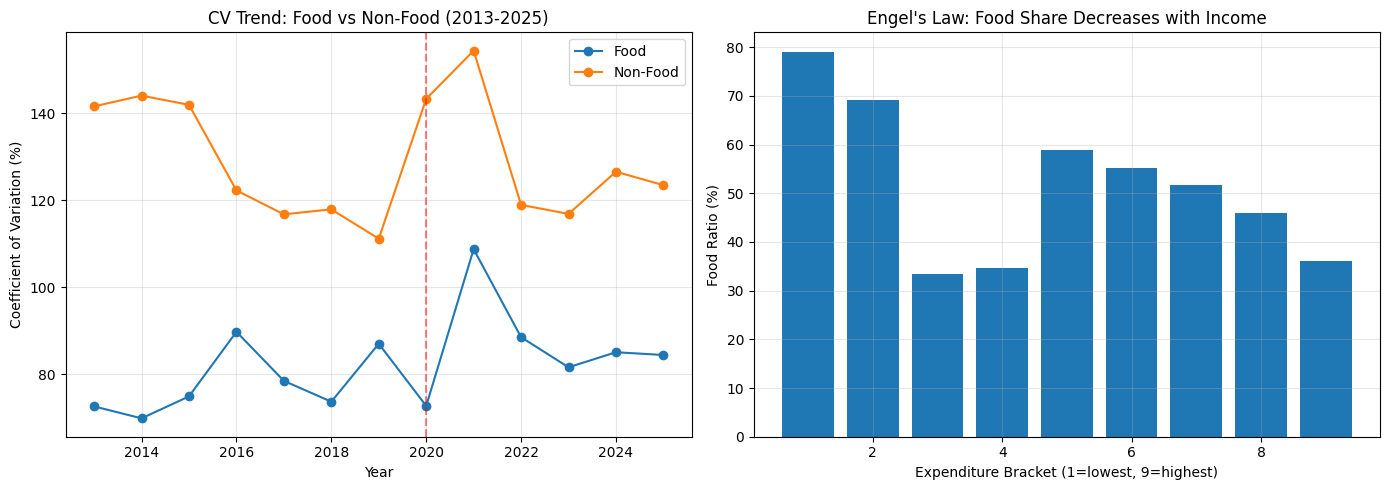

Saved to: results/figures/cv_trend_analysis.png


In [20]:
# Cell 18: CV Trend Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV by category over time
for cat in ['Food', 'Non-Food']:
    data = cv_by_category_year[cv_by_category_year['category'] == cat]
    axes[0].plot(data['year'], data['cv'], marker='o', label=cat)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Coefficient of Variation (%)')
axes[0].set_title('CV Trend: Food vs Non-Food (2013-2025)')
axes[0].legend()
axes[0].axvline(x=2020, color='red', linestyle='--', alpha=0.5, label='COVID')
axes[0].grid(True, alpha=0.3)

# Plot 2: Food ratio by bracket
axes[1].bar(engel_analysis.index, engel_analysis['food_ratio'])
axes[1].set_xlabel('Expenditure Bracket (1=lowest, 9=highest)')
axes[1].set_ylabel('Food Ratio (%)')
axes[1].set_title("Engel's Law: Food Share Decreases with Income")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cv_trend_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: results/figures/cv_trend_analysis.png")

In [21]:
# Cell 19: Summary Statistics for Paper
print("="*60)
print("SUMMARY STATISTICS FOR PAPER")
print("="*60)

print(f"\n1. DATA OVERVIEW")
print(f"   - Period: 2013-2025 ({df['year'].nunique()} years)")
print(f"   - Expenditure brackets: {df['expenditure_bracket'].nunique()}")
print(f"   - Consumption items: {df['item'].nunique()} (Food: {df[df['category']=='Food']['item'].nunique()}, Non-Food: {df[df['category']=='Non-Food']['item'].nunique()})")

print(f"\n2. COEFFICIENT OF VARIATION")
print(f"   - Overall CV range: {cv_item_year['cv'].min():.1f}% - {cv_item_year['cv'].max():.1f}%")
print(f"   - Food avg CV: {cv_item_year[cv_item_year['category']=='Food']['cv'].mean():.1f}%")
print(f"   - Non-Food avg CV: {cv_item_year[cv_item_year['category']=='Non-Food']['cv'].mean():.1f}%")

print(f"\n3. ENGEL'S LAW")
print(f"   - Correlation (income vs food share): {corr:.4f}")
print(f"   - Lowest bracket food ratio: {engel_analysis['food_ratio'].iloc[0]:.1f}%")
print(f"   - Highest bracket food ratio: {engel_analysis['food_ratio'].iloc[-1]:.1f}%")

print(f"\n4. STRUCTURAL PERIODS")
print(f"   - Pre-COVID (2013-2019): {len(df_features[df_features['is_covid']==0][df_features['is_post_covid']==0])} observations")
print(f"   - COVID (2020-2021): {len(df_features[df_features['is_covid']==1])} observations")
print(f"   - Post-COVID (2022-2025): {len(df_features[df_features['is_post_covid']==1])} observations")

print(f"\n5. FEATURE MATRIX")
print(f"   - Total features: {len(df_features.columns)}")
print(f"   - Observations (bracket × year): {len(df_features)}")

SUMMARY STATISTICS FOR PAPER

1. DATA OVERVIEW
   - Period: 2013-2025 (13 years)
   - Expenditure brackets: 11
   - Consumption items: 21 (Food: 13, Non-Food: 8)

2. COEFFICIENT OF VARIATION
   - Overall CV range: 20.9% - 256.7%
   - Food avg CV: 82.1%
   - Non-Food avg CV: 129.2%

3. ENGEL'S LAW
   - Correlation (income vs food share): 0.0399
   - Lowest bracket food ratio: 79.1%
   - Highest bracket food ratio: 36.2%

4. STRUCTURAL PERIODS
   - Pre-COVID (2013-2019): 56 observations
   - COVID (2020-2021): 16 observations
   - Post-COVID (2022-2025): 30 observations

5. FEATURE MATRIX
   - Total features: 34
   - Observations (bracket × year): 102
